# Lab1: LeNet
---

## 1 模型结构
本次实验实现的模型为`LeNet5`，在`CIFAR-10`数据集上进行分类实验。CIFAR-10数据集是彩色带标签图像数据集，
每张图像尺寸为$32\times 32$。因此图像具有3个通道，模型输入为$3\times 32 \times 32$。

模型结构依次如下：
- 卷积层1：图像输入深度=3，图像输出深度/卷积核个数=16，卷积核大小=$5\times 5$，步长=1
    （输入矩阵：$3\times 32\times 32$，输出矩阵：$16\times 28\times 28$）
- 池化层1：过滤器大小=$2\times 2$，步长=2
    （输出矩阵：$16\times 14\times 14$）
- 卷积层2：图像输入深度=卷积层1输出深度=16，图像输出深度=32，卷积核大小=$5\times 5$，步长=1
    （输出矩阵：$32\times 10\times 10$）
- 池化层2：过滤器大小=$2\times 2$，步长=2
    （输出矩阵：$32\times 5\times 5$）
- 全连接层1：输出节点120个
- 全连接层2：输出节点84个
- 全连接层3：输出节点10个

本次实验用到的库如下：

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        # convolution layer1
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        # pool layer1
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        # convolution layer2
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1)
        # pool layer2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layer1
        self.fc1 = nn.Linear(32*5*5,120)
        # fully connected layer2
        self.fc2 = nn.Linear(120,84)
        # fully connected layer3
        self.fc3 = nn.Linear(84,10)

    def forward(self,x):
        # convolution -> activation function -> pool
        x = F.relu(self.conv1(x))  # conv(3*32*32) -> activation(16*28*28)
        x = self.pool1(x)  # activation -> pool
        x = F.relu(self.conv2(x))
        x = self.pool2(x) 
        # reshape the output size automatically into 32*5*5
        x = x.view(-1, 32 * 5 * 5)  
        # fully connected -> activation function
        x = F.relu(self.fc1(x))  # output(120)
        x = F.relu(self.fc2(x))  # output(84)
        x = self.fc3(x)  # output(10)
        return x

`LeNet`类继承自`nn.Module`类，包括初始化函数和前向传播函数。本次实验使用`relu`函数作为激活函数，克服梯度消失问题。

---

## 2 数据集处理
从`torchvision.datasets`中下载数据集，包括训练集和测试集。

使用`transforms.Compose`拼接函数，使用`ToTensor`将Image转化为tensor格式，然后使用`normalize`将tensor标准化/归一化，加快模型收敛。

In [11]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# load data
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)
# the dataset's classes names
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


查看数据集中的数据情况，打印出一个batch。从数据集中直接获取到的image是tensor形式，需要反标准化将tensor转换成图像。使用`show`函数实现。

       ship       truck         cat         car


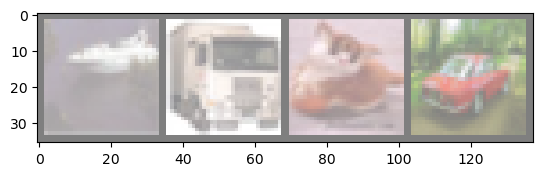

In [12]:
def show(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    # pytorch presentation: [channel, height, width]
    # plt use numpy: [height, width, channel]
    # use np.transpose() to change axis order
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.__next__()  # return 4 pics and labels
print(' '.join('%11s' % classes[labels[j]] for j in range(4)))  # print labels
show(torchvision.utils.make_grid((images + 1) / 2))

---

## 3 训练模型

使用交叉熵损失函数，同时选择Adam优化器优化，学习率设为0.001

In [14]:
# use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = LeNet()
net_model = net.to(device)

loss_function = nn.CrossEntropyLoss()
# choose Adam to optimize, learning rate=0.001
optimizer = optim.Adam(net.parameters(), lr=0.001)

max_epoch = 20 # train 20 epochs

训练总共进行20轮，在训练过程中绘制出损失函数变化和整体准确率变化，以及每一类的准确率变化。